<a href="https://colab.research.google.com/github/Ramanuja-Chanduri/Fake-Review-Identification-Model/blob/main/init-pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio numpy scipy scikit-image scikit-learn tqdm pandas matplotlib kymatio wandb -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import wiener
from kymatio import Scattering1D
import torch, torchaudio
from torchaudio.transforms import Resample
from torch.nn.functional import pad
from tqdm import tqdm
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
import wandb
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BatchNorm2d
from torchaudio.transforms import MelSpectrogram
import torchvision.models as models
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import os
import random
import shutil

In [ ]:
class AudioPreprocessor:
    def __init__(self,
                 sample_rate=47600,
                 target_samples=8000,
                 valid_bit_depths=[16, 24, 32],
                 min_duration_sec=0.1,
                 max_duration_sec=10.0,
                 device=None):

        self.sample_rate = sample_rate
        self.target_samples = target_samples
        self.valid_bit_depths = valid_bit_depths
        self.min_duration_sec = min_duration_sec
        self.max_duration_sec = max_duration_sec
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.resampler = None

    def load_audio(self, filepath):
        info = torchaudio.info(filepath)
        if info.bits_per_sample not in self.valid_bit_depths:
            return None, None

        waveform, sr = torchaudio.load(filepath)

        # Resample if needed
        if sr != self.sample_rate:
            if self.resampler is None or self.resampler.orig_freq != sr:
                self.resampler = Resample(orig_freq=sr, new_freq=self.sample_rate)
            waveform = self.resampler(waveform)

        return waveform, self.sample_rate

    def valid_duration(self, waveform):
        duration = waveform.shape[1] / self.sample_rate
        if duration < self.min_duration_sec:
            return -1
        elif duration > self.max_duration_sec:
            return 1
        else:
            return 0

    def center_cut_or_pad(self, waveform):
        length = waveform.shape[1]

        if length == self.target_samples:
            return waveform
        elif length > self.target_samples:
            center = length // 2
            left = center - (self.target_samples // 2)
            return waveform[:, left:left+self.target_samples]
        else:
            pad_total = self.target_samples - length
            pad_left = pad_total // 2
            pad_right = pad_total - pad_left
            return torch.nn.functional.pad(waveform, (pad_left, pad_right), mode='reflect')

    def basic_preprocess(self, root_folder):
        X_list = []
        y_list = []

        for root, dirs, files in os.walk(root_folder):
            for file in tqdm(files, desc=f"Processing {root}"):
                if file.endswith(".wav"):
                    filepath = os.path.join(root, file)
                    label = os.path.basename(os.path.dirname(filepath))

                    # Load and resample audio
                    waveform, sr = self.load_audio(filepath)
                    if waveform is None:
                        continue

                    # Check if the duration is valid
                    check = self.valid_duration(waveform)
                    if check == -1:
                        continue
                    elif check == 1:
                        # If too long, truncate to max duration
                        max_samples = int(self.max_duration_sec * self.sample_rate)
                        waveform = waveform[:, :max_samples]

                    # Apply center cut or padding
                    waveform = self.center_cut_or_pad(waveform)

                    # Add the waveform and label to the lists
                    X_list.append(waveform)
                    y_list.append(label)

        # Stack all tensors into one batch
        X = torch.cat(X_list, dim=0).to(self.device)
        y = np.array(y_list)

        return X, y

    def compute_mel(self, X, n_mels=32):
        device = self.device
        spectr = MelSpectrogram(
            sample_rate=self.sample_rate,
            n_mels=n_mels,
            normalized=True,
            window_fn=torch.hann_window
        ).to(device)

        X = X.to(device)
        MX = spectr(X)
        MX = MX.unsqueeze(1)  # [B, 1, n_mels, time]
        return MX

    def compute_wst(self, X, J=8, Q=14):
        device = self.device
        T = X.shape[1]
        scattering = Scattering1D(J=J, shape=T, Q=Q)

        X = X.detach().cpu().numpy()
        SX = torch.from_numpy(scattering(X)).to(device)

        # Normalize per scattering order
        meta = scattering.meta()
        order0 = np.where(meta['order'] == 0)[0]
        order1 = np.where(meta['order'] == 1)[0]
        order2 = np.where(meta['order'] == 2)[0]

        def median_norm(X):
            md = torch.median(X)
            sn = torch.std(X)
            return (X - md) / sn if sn > 1e-6 else X - md

        SX_med = SX.clone()
        for i in range(SX.shape[0]):
            SX_med[i, order0] = median_norm(SX[i, order0])
            SX_med[i, order1] = median_norm(SX[i, order1])
            SX_med[i, order2] = median_norm(SX[i, order2])

        SX_med = SX_med.unsqueeze(1)  # [B, 1, features]
        return SX_med

    def compute_mfcc(self, X, n_mfcc=13):
        device = self.device
        mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=self.sample_rate,
            n_mfcc=n_mfcc,
            melkwargs={
                'n_fft': 1024,
                'n_mels': 32,
                'hop_length': 512,
                'mel_scale': 'htk'
            }
        ).to(device)

        X = X.to(device)
        MFCC_features = mfcc_transform(X)
        MFCC_features = MFCC_features.unsqueeze(1)  # [B, 1, n_mfcc, time]
        return MFCC_features

In [ ]:
DATA_PATH = '/content/drive/MyDrive/Data'
BATCH_SIZE = 32

In [ ]:
preprocessor = AudioPreprocessor()

In [ ]:
X, y = preprocessor.basic_preprocess(DATA_PATH)

Processing /content/drive/MyDrive/Data: 0it [00:00, ?it/s]
Processing /content/drive/MyDrive/Data/atlantic_spotted_dolphin: 100%|██████████| 58/58 [00:02<00:00, 27.67it/s]
Processing /content/drive/MyDrive/Data/clymene_dolphin: 100%|██████████| 63/63 [00:02<00:00, 24.64it/s]
Processing /content/drive/MyDrive/Data/bottlenose_dolphin: 100%|██████████| 24/24 [00:00<00:00, 29.51it/s]
Processing /content/drive/MyDrive/Data/pantropical_spotted_dolphin: 100%|██████████| 66/66 [00:02<00:00, 26.98it/s]
Processing /content/drive/MyDrive/Data/common_dolphin: 100%|██████████| 52/52 [00:02<00:00, 19.58it/s]
Processing /content/drive/MyDrive/Data/spinner_dolphin: 100%|██████████| 114/114 [00:04<00:00, 23.58it/s]
Processing /content/drive/MyDrive/Data/white_beaked_dolphin: 100%|██████████| 57/57 [00:02<00:00, 28.00it/s]
Processing /content/drive/MyDrive/Data/rough_toothed_dolphin: 100%|██████████| 50/50 [00:01<00:00, 36.97it/s]
Processing /content/drive/MyDrive/Data/white_sided_dolphin: 100%|████████

In [ ]:
print(X.shape)

torch.Size([1501, 8000])


In [ ]:
mel_features = preprocessor.compute_mel(X)
wst_features = preprocessor.compute_wst(X)
mfcc_features = preprocessor.compute_mfcc(X)

In [ ]:
CLASSES = np.unique(y)
NUM_CLASSES = len(CLASSES)
ID2LABEL = {i: category.item() for i, category  in enumerate(CLASSES)}
LABEL2ID = {v : k for k, v in ID2LABEL.items()}

labels = torch.tensor([LABEL2ID[label] for label in y])
print(ID2LABEL)
print(LABEL2ID)
print(NUM_CLASSES)

{0: 'atlantic_spotted_dolphin', 1: 'bottlenose_dolphin', 2: 'bowhead_whale', 3: 'clymene_dolphin', 4: 'common_dolphin', 5: 'false_killer_whale', 6: 'finback_whale', 7: 'frasers_dolphin', 8: 'grampus_rissos_dolphin', 9: 'humpback_whale', 10: 'killer_whale', 11: 'long_finned_pilot_whale', 12: 'melon_headed_whale', 13: 'minke_whale', 14: 'northern_right_whale', 15: 'pantropical_spotted_dolphin', 16: 'rough_toothed_dolphin', 17: 'short_finned_pilot_whale', 18: 'southern_right_whale', 19: 'sperm_whale', 20: 'spinner_dolphin', 21: 'striped_dolphin', 22: 'white_beaked_dolphin', 23: 'white_sided_dolphin', 24: 'white_whale'}
{'atlantic_spotted_dolphin': 0, 'bottlenose_dolphin': 1, 'bowhead_whale': 2, 'clymene_dolphin': 3, 'common_dolphin': 4, 'false_killer_whale': 5, 'finback_whale': 6, 'frasers_dolphin': 7, 'grampus_rissos_dolphin': 8, 'humpback_whale': 9, 'killer_whale': 10, 'long_finned_pilot_whale': 11, 'melon_headed_whale': 12, 'minke_whale': 13, 'northern_right_whale': 14, 'pantropical_sp

In [ ]:
print(mel_features.shape)
print(wst_features.shape)
print(mfcc_features.shape)
print(labels.shape)

torch.Size([1501, 1, 32, 41])
torch.Size([1501, 1, 386, 31])
torch.Size([1501, 1, 13, 16])
torch.Size([1501])


In [ ]:
def visualize_samples(feature_tensor, feature_name='Feature', cmap="gray"):
    indices = random.sample(range(feature_tensor.shape[0]), 3)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    for i, idx in enumerate(indices):
        data = feature_tensor[idx][0].cpu().numpy()
        axes[i].imshow(data, cmap=cmap, aspect='auto')
        axes[i].set_title(f'{feature_name} - Random Sample {i + 1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

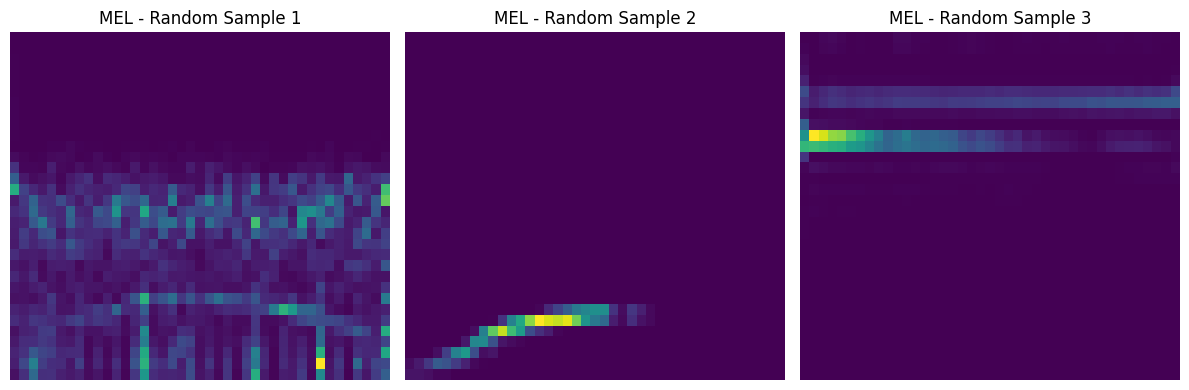

In [ ]:
visualize_samples(mel_features, "MEL", "viridis")

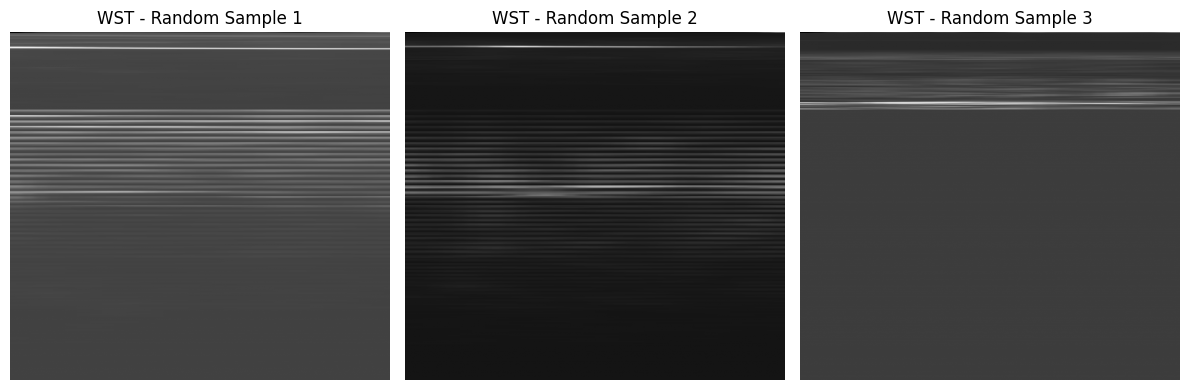

In [ ]:
visualize_samples(wst_features, "WST")

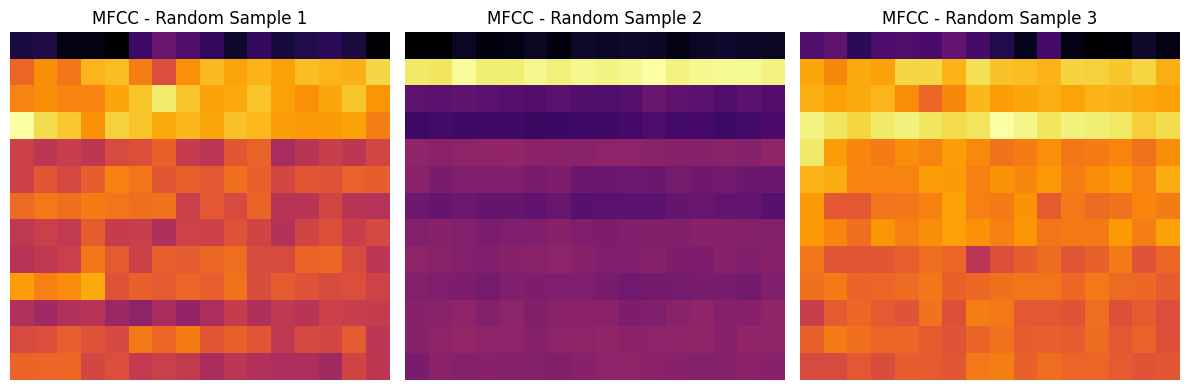

In [ ]:
visualize_samples(mfcc_features, "MFCC", "inferno")

In [ ]:
class CetaceanDataset(Dataset):
    def __init__(self, mfcc, wst, mel, labels):
        self.mfcc = mfcc
        self.wst = wst
        self.mel = mel
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.mfcc[idx], self.wst[idx], self.mel[idx], self.labels[idx]

In [ ]:
class MFCCDataset(Dataset):
    def __init__(self, mfcc, labels):
        self.mfcc = mfcc
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.mfcc[idx], self.labels[idx]

In [ ]:
class WSTDataset(Dataset):
    def __init__(self, wst, labels):
        self.wst = wst
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.wst[idx], self.labels[idx]

In [ ]:
class MELDataset(Dataset):
    def __init__(self, mel, labels):
        self.mel = mel
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.mel[idx], self.labels[idx]

In [ ]:
indices = np.random.permutation(len(labels))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels.numpy(), random_state=42)

In [ ]:
# For MFCC
train_mfcc_dataset = MFCCDataset(mfcc_features[train_idx], labels[train_idx])
val_mfcc_dataset = MFCCDataset(mfcc_features[val_idx], labels[val_idx])

train_mfcc_loader = DataLoader(train_mfcc_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_mfcc_loader = DataLoader(val_mfcc_dataset, batch_size=BATCH_SIZE, shuffle=False)

# For WST
train_wst_dataset = WSTDataset(wst_features[train_idx], labels[train_idx])
val_wst_dataset = WSTDataset(wst_features[val_idx], labels[val_idx])

train_wst_loader = DataLoader(train_wst_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_wst_loader = DataLoader(val_wst_dataset, batch_size=BATCH_SIZE, shuffle=False)

# For MEL
train_mel_dataset = MELDataset(mel_features[train_idx], labels[train_idx])
val_mel_dataset = MELDataset(mel_features[val_idx], labels[val_idx])

train_mel_loader = DataLoader(train_mel_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_mel_loader = DataLoader(val_mel_dataset, batch_size=BATCH_SIZE, shuffle=False)

# For Cetacean Net
train_dataset = CetaceanDataset(mfcc_features[train_idx], wst_features[train_idx], mel_features[train_idx], labels[train_idx])
val_dataset = CetaceanDataset(mfcc_features[val_idx], wst_features[val_idx], mel_features[val_idx], labels[val_idx])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# Test the loaders
for mfcc_data, mfcc_label in train_mfcc_loader:
    print("MFCC Train Loader:")
    print("Data shape:", mfcc_data.shape)
    print("Label shape:", mfcc_label.shape)
    break

for mfcc_data, mfcc_label in val_mfcc_loader:
    print("\nMFCC Validation Loader:")
    print("Data shape:", mfcc_data.shape)
    print("Label shape:", mfcc_label.shape)
    break

for wst_data, wst_label in train_wst_loader:
    print("\nWST Train Loader:")
    print("Data shape:", wst_data.shape)
    print("Label shape:", wst_label.shape)
    break

for wst_data, wst_label in val_wst_loader:
    print("\nWST Validation Loader:")
    print("Data shape:", wst_data.shape)
    print("Label shape:", wst_label.shape)
    break

for mel_data, mel_label in train_mel_loader:
    print("\nMEL Train Loader:")
    print("Data shape:", mel_data.shape)
    print("Label shape:", mel_label.shape)
    break

for mel_data, mel_label in val_mel_loader:
    print("\nMEL Validation Loader:")
    print("Data shape:", mel_data.shape)
    print("Label shape:", mel_label.shape)
    break

for mfcc_data, wst_data, mel_data, label in train_loader:
    print("\nFusion Train Loader:")
    print("MFCC Data shape:", mfcc_data.shape)
    print("WST Data shape:", wst_data.shape)
    print("MEL Data shape:", mel_data.shape)
    print("Label shape:", label.shape)
    break

for mfcc_data, wst_data, mel_data, label in val_loader:
    print("\nFusion Validation Loader:")
    print("MFCC Data shape:", mfcc_data.shape)
    print("WST Data shape:", wst_data.shape)
    print("MEL Data shape:", mel_data.shape)
    print("Label shape:", label.shape)
    break

MFCC Train Loader:
Data shape: torch.Size([32, 1, 13, 16])
Label shape: torch.Size([32])

MFCC Validation Loader:
Data shape: torch.Size([32, 1, 13, 16])
Label shape: torch.Size([32])

WST Train Loader:
Data shape: torch.Size([32, 1, 386, 31])
Label shape: torch.Size([32])

WST Validation Loader:
Data shape: torch.Size([32, 1, 386, 31])
Label shape: torch.Size([32])

MEL Train Loader:
Data shape: torch.Size([32, 1, 32, 41])
Label shape: torch.Size([32])

MEL Validation Loader:
Data shape: torch.Size([32, 1, 32, 41])
Label shape: torch.Size([32])

Fusion Train Loader:
MFCC Data shape: torch.Size([32, 1, 13, 16])
WST Data shape: torch.Size([32, 1, 386, 31])
MEL Data shape: torch.Size([32, 1, 32, 41])
Label shape: torch.Size([32])

Fusion Validation Loader:
MFCC Data shape: torch.Size([32, 1, 13, 16])
WST Data shape: torch.Size([32, 1, 386, 31])
MEL Data shape: torch.Size([32, 1, 32, 41])
Label shape: torch.Size([32])


In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        return self.norm(attn_output + x)

In [ ]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, query_dim, context_dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=query_dim, num_heads=heads, batch_first=True)
        self.k_proj = nn.Linear(context_dim, query_dim)
        self.v_proj = nn.Linear(context_dim, query_dim)
        self.norm = nn.LayerNorm(query_dim)

    def forward(self, query, context):
        key = self.k_proj(context)
        value = self.v_proj(context)
        attn_output, _ = self.attn(query, key, value)
        return self.norm(attn_output + query)

In [ ]:
class ModalFusionAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.weight_net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Tanh(),
            nn.Linear(dim, 1)
        )

    def forward(self, embeddings):
        weights = self.weight_net(embeddings).softmax(dim=1)
        return (weights * embeddings).sum(dim=1)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(4, in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(4, in_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class CetaceanNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # MEL: [B, 1, 32, 41] => conv2d -> [B, 128, 32, 41]
        self.mel_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            ResidualBlock(128),
        )
        self.mel_attn = SelfAttentionBlock(128)

        # WST: [B, 1, 386, 31] => conv2d -> [B, 128, 16, 8]
        self.wst_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            ResidualBlock(128),
            nn.AdaptiveAvgPool2d((16, 8))
        )
        self.wst_attn = SelfAttentionBlock(128)

        # MFCC: [B, 1, 13, 16] => conv2d -> [B, 128, 4, 4]
        self.mfcc_conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            ResidualBlock(128),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.mfcc_attn = SelfAttentionBlock(128)

        # Cross-attention
        self.cross_mfcc = CrossAttentionBlock(query_dim=128, context_dim=128)
        self.cross_wst = CrossAttentionBlock(query_dim=128, context_dim=128)

        # Fusion
        self.fusion_attention = ModalFusionAttention(128)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, mfcc, wst, mel):
        # MEL
        x_mel = self.mel_conv(mel)  # [B, 128, 32, 41]
        x_mel = x_mel.mean(dim=2).transpose(1, 2)  # [B, 41, 128]
        x_mel = self.mel_attn(x_mel)

        # WST
        x_wst = self.wst_conv(wst)  # [B, 128, 16, 8]
        x_wst = x_wst.flatten(2).transpose(1, 2)  # [B, 128, 128]
        x_wst = self.wst_attn(x_wst)

        # MFCC
        x_mfcc = self.mfcc_conv(mfcc)  # [B, 128, 4, 4]
        x_mfcc = x_mfcc.flatten(2).transpose(1, 2)  # [B, 16, 128]
        x_mfcc = self.mfcc_attn(x_mfcc)

        # Cross attention
        x_mel_mfcc = self.cross_mfcc(x_mel, x_mfcc)
        x_mel_wst = self.cross_wst(x_mel, x_wst)

        # Global average pooling
        pooled_mfcc = x_mel_mfcc.mean(dim=1)
        pooled_wst = x_mel_wst.mean(dim=1)


        # Fusion
        fused = torch.stack([pooled_mfcc, pooled_wst], dim=1)  # [B, 2, 128]
        out = self.fusion_attention(fused)
        result = self.classifier(out)

        return result

In [ ]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, stride=1):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, kernel_size=kernel_size, stride=stride,
            padding=padding, groups=in_channels, bias=False
        )
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, bias=False
        )
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [ ]:
class LightResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.dsconv1 = DepthwiseSeparableConv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.GroupNorm(4, in_channels)
        self.relu = nn.ReLU()
        self.dsconv2 = DepthwiseSeparableConv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.GroupNorm(4, in_channels)

    def forward(self, x):
        residual = x
        out = self.dsconv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dsconv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class CetaceanNetLight(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # MEL: [B, 1, 32, 41] => conv2d -> [B, 128, 32, 41]
        self.mel_conv = nn.Sequential(
            DepthwiseSeparableConv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            DepthwiseSeparableConv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            LightResidualBlock(128),
        )
        self.mel_attn = SelfAttentionBlock(128)

        # WST: [B, 1, 386, 31] => conv2d -> [B, 128, 16, 8]
        self.wst_conv = nn.Sequential(
            DepthwiseSeparableConv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            DepthwiseSeparableConv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            LightResidualBlock(128),
            nn.AdaptiveAvgPool2d((16, 8))
        )
        self.wst_attn = SelfAttentionBlock(128)

        # MFCC: [B, 1, 13, 16] => conv2d -> [B, 128, 4, 4]
        self.mfcc_conv = nn.Sequential(
            DepthwiseSeparableConv2d(1, 64, kernel_size=3, padding=1),
            nn.GroupNorm(4, 64), nn.ReLU(),
            DepthwiseSeparableConv2d(64, 128, kernel_size=3, padding=1),
            nn.GroupNorm(4, 128), nn.ReLU(),
            LightResidualBlock(128),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.mfcc_attn = SelfAttentionBlock(128)

        # Cross-attention
        self.cross_mfcc = CrossAttentionBlock(query_dim=128, context_dim=128)
        self.cross_wst = CrossAttentionBlock(query_dim=128, context_dim=128)

        # Fusion
        self.fusion_attention = ModalFusionAttention(128)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, mfcc, wst, mel):
        # MEL
        x_mel = self.mel_conv(mel)  # [B, 128, 32, 41]
        x_mel = x_mel.mean(dim=2).transpose(1, 2)  # [B, 41, 128]
        x_mel = self.mel_attn(x_mel)

        # WST
        x_wst = self.wst_conv(wst)  # [B, 128, 16, 8]
        x_wst = x_wst.flatten(2).transpose(1, 2)  # [B, 128, 128]
        x_wst = self.wst_attn(x_wst)

        # MFCC
        x_mfcc = self.mfcc_conv(mfcc)  # [B, 128, 4, 4]
        x_mfcc = x_mfcc.flatten(2).transpose(1, 2)  # [B, 16, 128]
        x_mfcc = self.mfcc_attn(x_mfcc)

        # Cross attention
        x_mel_mfcc = self.cross_mfcc(x_mel, x_mfcc)
        x_mel_wst = self.cross_wst(x_mel, x_wst)

        # Global average pooling
        pooled_mfcc = x_mel_mfcc.mean(dim=1)
        pooled_wst = x_mel_wst.mean(dim=1)

        # Fusion
        fused = torch.stack([pooled_mfcc, pooled_wst], dim=1)  # [B, 2, 128]
        out = self.fusion_attention(fused)
        result = self.classifier(out)

        return result

In [ ]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.target_size = (224, 224)

        self.backbone = models.mobilenet_v2(pretrained=False)
        self.backbone.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.backbone.classifier[1] = nn.Linear(self.backbone.last_channel, num_classes)

    def forward(self, feature):
        feature = F.interpolate(feature, size=self.target_size, mode='bilinear', align_corners=False)
        return self.backbone(feature)

In [ ]:
class MobileNetV2Combined(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.target_size = (224, 224)

        self.backbone = models.mobilenet_v2(pretrained=True)
        self.backbone.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.backbone.classifier[1] = nn.Linear(self.backbone.last_channel, num_classes)

    def forward(self, mfcc, wst, mel):
        # Interpolate all inputs to the same size
        mfcc = F.interpolate(mfcc, size=self.target_size, mode='bilinear', align_corners=False)  # [B, 1, H, W]
        wst  = F.interpolate(wst,  size=self.target_size, mode='bilinear', align_corners=False)
        mel  = F.interpolate(mel,  size=self.target_size, mode='bilinear', align_corners=False)

        # Concatenate along channel dimension -> [B, 3, H, W]
        combined = torch.cat([mfcc, wst, mel], dim=1)
        return self.backbone(combined)

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    y,
    label2id,
    num_classes,
    project_name="cetacean-net",
    architecture="Default",
    epochs=100,
    batch_size=32,
    learning_rate=1e-4,
    optimizer_name="AdamW",
    weight_decay=1e-2
):
    # WANDB INIT
    wandb.init(
        project=project_name,
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": learning_rate,
            "optimizer": optimizer_name,
            "architecture": architecture
        }
    )

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Class weights for imbalanced datasets
    class_np = np.array(range(num_classes))
    labels = torch.tensor([label2id[label] for label in y])
    class_weights = compute_class_weight('balanced', classes=class_np, y=labels.cpu().numpy())
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    if optimizer_name.lower() == "adamw":
        optimizer = optim.AdamW(
            model.parameters(),
            lr=learning_rate,
            weight_decay=weight_decay,
        )
    else:
        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0

        for batch in train_loader:
            # Unpack batch (supports multi-input or single-input models)
            if isinstance(batch, (list, tuple)) and len(batch) == 4:
                x1, x2, x3, labels = batch
                x1, x2, x3, labels = x1.to(device), x2.to(device), x3.to(device), labels.to(device)
                outputs = model(x1.float(), x2.float(), x3.float())
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs.float())

            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / total_train
        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                if isinstance(batch, (list, tuple)) and len(batch) == 4:
                    x1, x2, x3, labels = batch
                    x1, x2, x3, labels = x1.to(device), x2.to(device), x3.to(device), labels.to(device)
                    outputs = model(x1.float(), x2.float(), x3.float())
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs.float())

                loss = criterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = val_loss / total_val
        val_accuracy = correct_val / total_val

        # Log metrics
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss,
            "train_accuracy": train_accuracy,
            "val_loss": avg_val_loss,
            "val_accuracy": val_accuracy
        })

        print(
            f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}"
        )

In [ ]:
cetacean_net = CetaceanNet(num_classes=NUM_CLASSES)

train_model(
    model=cetacean_net,
    train_loader=train_loader,
    val_loader=val_loader,
    y=y,
    label2id=LABEL2ID,
    num_classes=NUM_CLASSES,
    project_name="cetacean-net",
    architecture="Multimodal Attention-Based CNN",
    epochs=60,
    batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    optimizer_name="AdamW",
)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
train_accuracy,▁▂▂▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇███████▇████
train_loss,█▇▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_accuracy,▁▁▂▃▄▅▆▆▆▆▆▇▇▇▇▇█▇▇█▇█▇███████▇█████████
val_loss,██▆▆▅▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,60
train_accuracy,0.94833
train_loss,0.13148
val_accuracy,0.74751
val_loss,0.82468


Total parameters: 1535770
Trainable parameters: 1535770
Epoch 1 | Train Loss: 3.1939 | Train Acc: 0.0667 | Val Loss: 3.1460 | Val Acc: 0.0797
Epoch 2 | Train Loss: 3.0228 | Train Acc: 0.1067 | Val Loss: 3.0069 | Val Acc: 0.0897
Epoch 3 | Train Loss: 2.8926 | Train Acc: 0.1208 | Val Loss: 2.8881 | Val Acc: 0.1362
Epoch 4 | Train Loss: 2.7828 | Train Acc: 0.1300 | Val Loss: 2.7253 | Val Acc: 0.1761
Epoch 5 | Train Loss: 2.6500 | Train Acc: 0.1950 | Val Loss: 2.5973 | Val Acc: 0.2625
Epoch 6 | Train Loss: 2.5036 | Train Acc: 0.2567 | Val Loss: 2.4801 | Val Acc: 0.2924
Epoch 7 | Train Loss: 2.3526 | Train Acc: 0.3033 | Val Loss: 2.3329 | Val Acc: 0.3389
Epoch 8 | Train Loss: 2.2191 | Train Acc: 0.3617 | Val Loss: 2.1387 | Val Acc: 0.4718
Epoch 9 | Train Loss: 2.0732 | Train Acc: 0.4275 | Val Loss: 2.0379 | Val Acc: 0.5216
Epoch 10 | Train Loss: 1.9275 | Train Acc: 0.4750 | Val Loss: 1.8456 | Val Acc: 0.5449
Epoch 11 | Train Loss: 1.7736 | Train Acc: 0.5267 | Val Loss: 1.7666 | Val Acc: 0.5

In [ ]:
cetacean_net_light = CetaceanNetLight(num_classes=NUM_CLASSES)

train_model(
    model=cetacean_net_light,
    train_loader=train_loader,
    val_loader=val_loader,
    y=y,
    label2id=LABEL2ID,
    num_classes=NUM_CLASSES,
    project_name="cetacean-net",
    architecture="Lightweight version of CetaceanNet: A Multimodal Attention-Based CNN",
    epochs=60,
    batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    optimizer_name="AdamW",
)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train_loss,██▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██▇██████▇██████████
val_loss,██▇▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,60
train_accuracy,0.915
train_loss,0.24566
val_accuracy,0.73754
val_loss,0.95398


Total parameters: 558517
Trainable parameters: 558517
Epoch 1 | Train Loss: 3.2276 | Train Acc: 0.0458 | Val Loss: 3.1957 | Val Acc: 0.0399
Epoch 2 | Train Loss: 3.1743 | Train Acc: 0.0625 | Val Loss: 3.1378 | Val Acc: 0.0698
Epoch 3 | Train Loss: 3.0826 | Train Acc: 0.0958 | Val Loss: 3.0055 | Val Acc: 0.1794
Epoch 4 | Train Loss: 2.9001 | Train Acc: 0.1475 | Val Loss: 2.8386 | Val Acc: 0.1694
Epoch 5 | Train Loss: 2.7526 | Train Acc: 0.1850 | Val Loss: 2.6912 | Val Acc: 0.2824
Epoch 6 | Train Loss: 2.6281 | Train Acc: 0.2158 | Val Loss: 2.5845 | Val Acc: 0.2757
Epoch 7 | Train Loss: 2.4871 | Train Acc: 0.2925 | Val Loss: 2.4333 | Val Acc: 0.3654
Epoch 8 | Train Loss: 2.3656 | Train Acc: 0.3200 | Val Loss: 2.3430 | Val Acc: 0.3887
Epoch 9 | Train Loss: 2.2404 | Train Acc: 0.3742 | Val Loss: 2.2321 | Val Acc: 0.4252
Epoch 10 | Train Loss: 2.1350 | Train Acc: 0.3833 | Val Loss: 2.1300 | Val Acc: 0.4419
Epoch 11 | Train Loss: 2.0204 | Train Acc: 0.4133 | Val Loss: 2.0369 | Val Acc: 0.478

In [ ]:
mobilenetv2_combined = MobileNetV2Combined(num_classes=NUM_CLASSES)

train_model(
    model=mobilenetv2_combined,
    train_loader=train_loader,
    val_loader=val_loader,
    y=y,
    label2id=LABEL2ID,
    num_classes=NUM_CLASSES,
    project_name="cetacean-net",
    architecture="MobileNet V2, with all three features",
    epochs=60,
    batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    optimizer_name="AdamW",
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
train_accuracy,▁▄▆▆▇███████████████████████████████████
train_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇██▇▇▇██▇▇▇▇▇█
val_loss,█▄▃▂▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▃▃▂▂▂▃▂▂▃▂▃▃▃▃▃▃▃▄▃▄
epoch,60
train_accuracy,0.96333
train_loss,0.04385
val_accuracy,0.76412
val_loss,1.23698


Total parameters: 2255897
Trainable parameters: 2255897
Epoch 1 | Train Loss: 2.6898 | Train Acc: 0.2775 | Val Loss: 2.1048 | Val Acc: 0.4684
Epoch 2 | Train Loss: 1.6097 | Train Acc: 0.6108 | Val Loss: 1.4021 | Val Acc: 0.6179
Epoch 3 | Train Loss: 1.0191 | Train Acc: 0.7458 | Val Loss: 1.0810 | Val Acc: 0.6944
Epoch 4 | Train Loss: 0.6768 | Train Acc: 0.8250 | Val Loss: 0.8938 | Val Acc: 0.7342
Epoch 5 | Train Loss: 0.4384 | Train Acc: 0.8867 | Val Loss: 0.8101 | Val Acc: 0.7442
Epoch 6 | Train Loss: 0.3062 | Train Acc: 0.9142 | Val Loss: 0.7929 | Val Acc: 0.7442
Epoch 7 | Train Loss: 0.2167 | Train Acc: 0.9383 | Val Loss: 0.7231 | Val Acc: 0.7807
Epoch 8 | Train Loss: 0.1621 | Train Acc: 0.9458 | Val Loss: 0.7637 | Val Acc: 0.7575
Epoch 9 | Train Loss: 0.1314 | Train Acc: 0.9592 | Val Loss: 0.7556 | Val Acc: 0.7542
Epoch 10 | Train Loss: 0.1162 | Train Acc: 0.9525 | Val Loss: 0.7697 | Val Acc: 0.7641
Epoch 11 | Train Loss: 0.0957 | Train Acc: 0.9592 | Val Loss: 0.7732 | Val Acc: 0.7

In [ ]:
mobilenetv2_mel = MobileNetV2(num_classes=NUM_CLASSES)

train_model(
    model=mobilenetv2_mel,
    train_loader=train_mel_loader,
    val_loader=val_mel_loader,
    y=y,
    label2id=LABEL2ID,
    num_classes=NUM_CLASSES,
    project_name="cetacean-net",
    architecture="MobileNet V2, with MEL Features",
    epochs=60,
    batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    optimizer_name="AdamW",
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_accuracy,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█▇█████████████
train_loss,█▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▄▃▃▅▅▄▃▅▆▅▆▆▇▆▃▄▇▇▃▆▃▇▃▂▅▃▃▅▆▆▆▆██▅▄▂
val_loss,▁▂▃▅▆▄▅▂▅▃▅▄▄▃▄▄▃▄▅▅▄▆▄▃▅██▄▅▆▅▅▄▆▄▆▃▆▅▆
epoch,60
train_accuracy,0.9325
train_loss,0.15449
val_accuracy,0.06312
val_loss,7.66386


Total parameters: 2255321
Trainable parameters: 2255321
Epoch 1 | Train Loss: 3.1379 | Train Acc: 0.0833 | Val Loss: 3.2769 | Val Acc: 0.0432
Epoch 2 | Train Loss: 2.9102 | Train Acc: 0.1617 | Val Loss: 3.3407 | Val Acc: 0.0532
Epoch 3 | Train Loss: 2.6904 | Train Acc: 0.1767 | Val Loss: 3.0635 | Val Acc: 0.1329
Epoch 4 | Train Loss: 2.4922 | Train Acc: 0.2058 | Val Loss: 2.7548 | Val Acc: 0.1561
Epoch 5 | Train Loss: 2.3515 | Train Acc: 0.2600 | Val Loss: 2.6780 | Val Acc: 0.1595
Epoch 6 | Train Loss: 2.1977 | Train Acc: 0.3375 | Val Loss: 2.9919 | Val Acc: 0.1229
Epoch 7 | Train Loss: 2.0577 | Train Acc: 0.3292 | Val Loss: 3.8926 | Val Acc: 0.1130
Epoch 8 | Train Loss: 1.9597 | Train Acc: 0.3925 | Val Loss: 7.4377 | Val Acc: 0.1030
Epoch 9 | Train Loss: 1.8446 | Train Acc: 0.4225 | Val Loss: 3.8091 | Val Acc: 0.1262
Epoch 10 | Train Loss: 1.7285 | Train Acc: 0.4483 | Val Loss: 2.8094 | Val Acc: 0.1993
Epoch 11 | Train Loss: 1.6448 | Train Acc: 0.4833 | Val Loss: 3.2688 | Val Acc: 0.1

In [ ]:
mobilenetv2_mfcc = MobileNetV2(num_classes=NUM_CLASSES)

train_model(
    model=mobilenetv2_mfcc,
    train_loader=train_mfcc_loader,
    val_loader=val_mfcc_loader,
    y=y,
    label2id=LABEL2ID,
    num_classes=NUM_CLASSES,
    project_name="cetacean-net",
    architecture="MobileNet V2, with MFCC Features",
    epochs=60,
    batch_size=BATCH_SIZE,
    learning_rate=1e-4,
    optimizer_name="AdamW",
)